In [1]:
1+1


2

In [2]:
import uproot
import matplotlib.pyplot as plt 
import pandas as pd 
import numpy as np 
import matplotlib as mpl
import h5py
import math

from util import *

import var
import cut
import data
import hist

import importlib

from pyanalib import panda_helpers
from unc_funcs import *

/icarus/app/users/jdyer/dev_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib/python3.9/site-packages/scipy/__init__.py:132: UserWarning: A NumPy version >=1.21.6 and <1.28.0 is required for this version of SciPy (detected version 1.20.1)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[0.39431672 0.04210058 0.91800973]


In [3]:
importlib.reload(var)
importlib.reload(cut)
importlib.reload(data)
importlib.reload(hist)
importlib.reload(panda_helpers)

<module 'pyanalib.panda_helpers' from '/exp/icarus/app/users/jdyer/dev_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py'>

In [4]:
plt.rcParams.update({'font.size': 16})
mpl.rcParams['lines.linewidth'] = 4.

dosave = False
savedir = "/icarus/app/users/gputnam/evtsel-ana/plots_Jan9/"

savedata = False
datadir = "/icarus/data/users/gputnam/dimuon-data/"

HMASS = 260
labelM = "$M_S$ = %iMeV" % HMASS
label = labelM + "\n$\\theta_S = 5\\cdot10^{-5}$"

# AMASS = 400
# labelM = "$M_a$ = %i MeV" % AMASS
# label = labelM + "\n$f_a$ = \n$c_\\ell$ ="

In [5]:
#fh = "/icarus/data/users/gputnam/dimuon-data/higgs-gen-A/higgs_M260_DMCP2023G_evt.df" #what I originally used for this study.
fh = "/icarus/data/users/gputnam/dimuon-data/higgs-gen-A/higgs_M260_DMCP2023G_evt_new.df" #updated to here 11/20/23 (prelim prep)

In [6]:
h_evtdf = pd.read_hdf(fh, key="evt")
#h_evtdf
#for c in h_evtdf.columns:
#    print(c)
#print(h_evtdf.shape)
#help(h_evtdf)

In [7]:
#redefine make_categories here b/c this dataframe does not have "sample" index.

def make_categories(df):
    is_higgs = (df.slc.tmatch.idx >= 0) & df.higgs & (df.slc.truth.npi == 0) & (df.slc.truth.npi0 == 0) # Only consider muon channel, exclude any Higgs that decayed to pions.
    #print(type(is_higgs))
    is_higgs.name = "Scalar"
    is_nu = (df.slc.tmatch.idx >= 0) & ~df.higgs
    is_nu.name = "$\\nu$"
    is_cosmic = df.slc.tmatch.idx < 0 # from higgs or nus, so I'm assuming both samples include cosmics.
    is_cosmic.name = "Cosmic"

    categories = [is_higgs, is_nu, is_cosmic]
    return categories

In [8]:
h_evtdf["higgs"] = True
evtdf = h_evtdf[make_categories(h_evtdf)[0]] # signal only (no cosmics)
print(evtdf.shape)

(2481, 186)


In [9]:
when = SlcInFV(evtdf.slc.vertex) & ~TrkInFV(evtdf.trunk.trk.end) & TrkInFV(evtdf.branch.trk.end)
unc_trunk_evtdf = evtdf[when]
print('Uncontained trunk (only): ', unc_trunk_evtdf.shape)

when = SlcInFV(evtdf.slc.vertex) & TrkInFV(evtdf.trunk.trk.end) & ~TrkInFV(evtdf.branch.trk.end)
unc_branch_evtdf = evtdf[when]
print('Uncontained branch (only): ', unc_branch_evtdf.shape)

when = SlcInFV(evtdf.slc.vertex) & ~TrkInFV(evtdf.trunk.trk.end) & ~TrkInFV(evtdf.branch.trk.end)
unc_both_evtdf = evtdf[when]
print('Both uncontained: ', unc_both_evtdf.shape)

#unc_h_evtdf = sample_concat(h_evtdf, nu_evtdf, offset=1_000_000)
unc_evtdf = unc_trunk_evtdf.append(unc_branch_evtdf).append(unc_both_evtdf)
print('Anything not contained: ', unc_evtdf.shape)

when = SlcInFV(evtdf.slc.vertex) & TrkInFV(evtdf.trunk.trk.end) & TrkInFV(evtdf.branch.trk.end)
con_evtdf = evtdf[when]
print('Totally contained: ', con_evtdf.shape)

#when = SlcInFV(h_evtdf.slc.vertex)
#print('All the Higgs Events with contained vertex: ', h_evtdf[when].shape)
print('All the Higgs Events with contained vertex: ', evtdf.shape)

Uncontained trunk (only):  (455, 186)
Uncontained branch (only):  (216, 186)
Both uncontained:  (312, 186)
Anything not contained:  (983, 186)
Totally contained:  (1498, 186)
All the Higgs Events with contained vertex:  (2481, 186)


/tmp/ipykernel_9354/2543317900.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  unc_evtdf = unc_trunk_evtdf.append(unc_branch_evtdf).append(unc_both_evtdf)
/tmp/ipykernel_9354/2543317900.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  unc_evtdf = unc_trunk_evtdf.append(unc_branch_evtdf).append(unc_both_evtdf)


In [10]:
unc_branch_h_evtdf

slc                          \
                              is_clear_cosmic      vertex               
                                                        x           y   
                                                                        
                                                                        
                                                                        
__ntuple entry rec.slc..index                                           
1        0     0                            0 -296.280212   98.545502   
         17    12                           0  178.943176  118.468117   
16       11    24                           0  147.301697  -64.097900   
         15    15                           0  126.095474  -87.939102   
         17    14                           0  271.417114  -97.160858   
..                                        ...         ...         ...   
401      1     0                            0 -113.133377 -122.198524   
         9     0                            0 -262.993774   40.427124   
400      14    2                            0 -146.103394 -157.980743   
403      8     0                            0 -253.997742   86.235718   
         20    13                           0  261.973877   47.367706   

                                                                         \
                                          self    tmatch                  
                                        z            eff       pur  idx   
                                                                          
                                                                          
                                                                          
__ntuple entry rec.slc..index                                             
1        0     0              -617.396545  177  0.817304  0.987288    0   
         17    12               32.523952  257  0.728989  0.989488    0   
16       11    24              391.259583  247       NaN       NaN -999   
         15    15             -240.857285  228       NaN       NaN -999   
         17    14              427.616302   78       NaN       NaN -999   
..                                    ...  ...       ...       ...  ...   
401      1     0              -201.668442  246  0.704703  0.988748    0   
         9     0              -626.515259   46  0.879639  0.996269    0   
400      14    2               575.220520  211  0.887295  0.958014    0   
403      8     0               291.277191  158       NaN       NaN -999   
         20    13             -597.972046  263  0.921968  0.928038    0   

                                                      ...  \
                              producer          nuid  ...   
                                       crlongtrkdiry  ...   
                                                      ...   
                                                      ...   
                                                      ...   
__ntuple entry rec.slc..index                         ...   
1        0     0                     0     -0.309843  ...   
         17    12                    1     -0.071571  ...   
16       11    24                    1     -0.963581  ...   
         15    15                    1     -0.878598  ...   
         17    14                    1     -0.631088  ...   
..                                 ...           ...  ...   
401      1     0                     0     -0.129707  ...   
         9     0                     0      0.041754  ...   
400      14    2                     0     -0.126799  ...   
403      8     0                     0     -0.307782  ...   
         20    13                    1     -0.189728  ...   

                              third_trk_chi2_proton third_trk_chi2_muon  \
                                                                          
                                                                          
                                                    

In [15]:
unc_both_h_evtdf

slc                          \
                              is_clear_cosmic      vertex               
                                                        x           y   
                                                                        
                                                                        
                                                                        
__ntuple entry rec.slc..index                                           
1        24    1                            0 -111.723831  -16.369080   
20       12    1                            0 -127.546875  106.415894   
10       1     22                           0  121.158401 -134.808044   
         5     12                           0   72.196297  -11.945442   
         24    1                            0 -114.421906   42.088135   
..                                        ...         ...         ...   
389      16    24                           0  283.541077 -137.524567   
         21    1                            0 -228.281799 -166.299622   
398      2     15                           0  281.049652 -141.656235   
401      16    22                           0  247.868729   53.208374   
         22    0                            0 -161.666306  -68.836357   

                                                                        \
                                          self    tmatch                 
                                        z            eff       pur idx   
                                                                         
                                                                         
                                                                         
__ntuple entry rec.slc..index                                            
1        24    1               745.549500  164  0.916458  0.965077   0   
20       12    1              -760.554932  118  0.911302  0.951251   0   
10       1     22              736.326721  310  0.886600  0.991484   0   
         5     12              104.199196  177  0.830592  0.992099   0   
         24    1              -749.383240  243  0.415440  0.953721   0   
..                                    ...  ...       ...       ...  ..   
389      16    24              -64.930313  271  0.869223  0.991159   0   
         21    1               740.189331  217  0.796961  0.986356   0   
398      2     15              251.751160   96  0.859945  0.998762   0   
401      16    22              322.328613  190  0.887127  0.942469   0   
         22    0               -53.345688  129  0.896626  0.969921   0   

                                                      ...  \
                              producer          nuid  ...   
                                       crlongtrkdiry  ...   
                                                      ...   
                                                      ...   
                                                      ...   
__ntuple entry rec.slc..index                         ...   
1        24    1                     0      0.047957  ...   
20       12    1                     0     -0.064460  ...   
10       1     22                    1     -0.034347  ...   
         5     12                    1     -0.039770  ...   
         24    1                     0      0.041248  ...   
..                                 ...           ...  ...   
389      16    24                    1     -0.039672  ...   
         21    1                     0     -0.040087  ...   
398      2     15                    1      0.013016  ...   
401      16    22                    1      0.050922  ...   
         22    0                     0     -0.311769  ...   

                              third_trk_chi2_proton third_trk_chi2_muon  \
                                                                          
                                                                          
                                                                      

In [34]:
for c in unc_h_evtdf.columns:
    print(c)

('slc', 'is_clear_cosmic', '', '', '', '')
('slc', 'vertex', 'x', '', '', '')
('slc', 'vertex', 'y', '', '', '')
('slc', 'vertex', 'z', '', '', '')
('slc', 'self', '', '', '', '')
('slc', 'tmatch', 'eff', '', '', '')
('slc', 'tmatch', 'pur', '', '', '')
('slc', 'tmatch', 'idx', '', '', '')
('slc', 'producer', '', '', '', '')
('slc', 'nuid', 'crlongtrkdiry', '', '', '')
('slc', 'truth', 'E', '', '', '')
('slc', 'truth', 'position', 'x', '', '')
('slc', 'truth', 'position', 'y', '', '')
('slc', 'truth', 'position', 'z', '', '')
('slc', 'truth', 'pdg', '', '', '')
('slc', 'truth', 'iscc', '', '', '')
('slc', 'truth', 'genie_mode', '', '', '')
('slc', 'truth', 'max_proton_ke', '', '', '')
('slc', 'truth', 'nn', '', '', '')
('slc', 'truth', 'np', '', '', '')
('slc', 'truth', 'npi', '', '', '')
('slc', 'truth', 'npi0', '', '', '')
('slc', 'truth', 'ng', '', '', '')
('slc', 'truth', 'nk', '', '', '')
('slc', 'truth', 'nk0', '', '', '')
('slc', 'truth', 'lmom', '', '', '')
('dist_to_vertex', '

In [10]:
# Note: these ones are not neccessarily orthogonal samples.

when_trunk_con = SlcInFV(evtdf.slc.vertex) & TrkInFV(evtdf.trunk.trk.end) 
when_trunk_unc = SlcInFV(evtdf.slc.vertex) & ~TrkInFV(evtdf.trunk.trk.end)
when_branch_con = SlcInFV(evtdf.slc.vertex) & TrkInFV(evtdf.branch.trk.end)
when_branch_unc = SlcInFV(evtdf.slc.vertex) & ~TrkInFV(evtdf.branch.trk.end)

# Check the Tracks' Particle ID Xi^2 Values

Gray's Definitions for Muon/Proton separation:
```python
    
def is_muon(trk):
    return (TrkInFV(trk.end) & (trk.chi2pid.I2.chi2_muon < 40) & (trk.chi2pid.I2.chi2_proton > 80)) | (~TrkInFV(trk.end) & (trk.len > 100.))

def is_proton(trk):
    return TrkInFV(trk.end) & (trk.chi2pid.I2.chi2_muon > 40) & (trk.chi2pid.I2.chi2_proton < 60)
```



52.30516


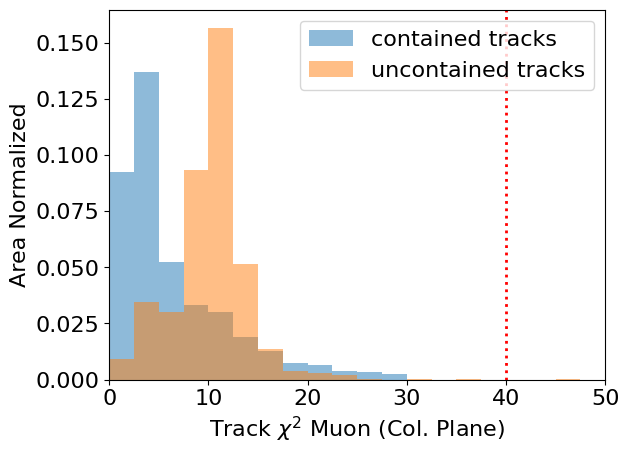

412.15103


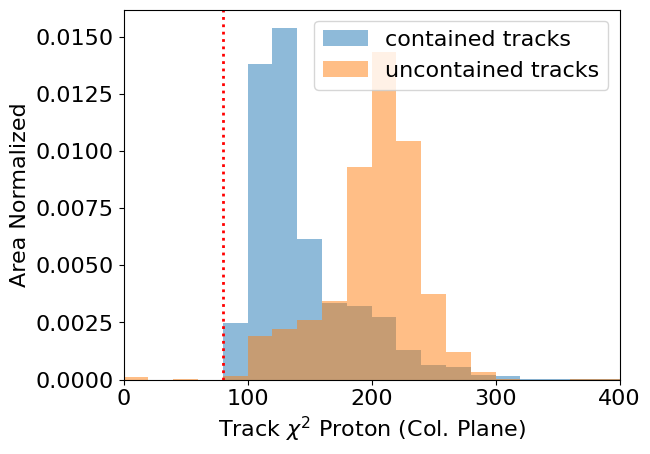

In [11]:
# Muon x2

mybins = 20
myrange = (0,50)
myDensity = True
print(np.max(evtdf.trunk.trk.chi2pid.I2.chi2_muon))
#plt.hist(evtdf[when_trunk_con].trunk.trk.chi2pid.I2.chi2_muon, histtype = 'step', 
#         label='contained trunk', bins=mybins, range=myrange, linewidth=2, density=myDensity)
#plt.hist(evtdf[when_trunk_unc].trunk.trk.chi2pid.I2.chi2_muon, histtype = 'step', 
#         label='uncontained trunk', bins=mybins, range=myrange, linewidth=2, density=myDensity, 
#         color='C0', linestyle='--')
#plt.hist(evtdf[when_branch_con].branch.trk.chi2pid.I2.chi2_muon, histtype = 'step', 
#         label='contained branch', bins=mybins, range=myrange, linewidth=2, density=myDensity)
#plt.hist(evtdf[when_branch_unc].branch.trk.chi2pid.I2.chi2_muon, histtype = 'step', 
#         label='uncontained branch', bins=mybins, range=myrange, linewidth=2, density=myDensity, 
#         color='C1', linestyle='--')
plt.hist(np.concatenate((evtdf[when_branch_con].branch.trk.chi2pid.I2.chi2_muon,
                        evtdf[when_trunk_con].trunk.trk.chi2pid.I2.chi2_muon)), 
         label='contained tracks', bins=mybins, range=myrange, linewidth=2, density=myDensity, alpha=0.5)
        #, histtype = 'step', color='#D054F1')
plt.hist(np.concatenate((evtdf[when_trunk_unc].trunk.trk.chi2pid.I2.chi2_muon, 
                         evtdf[when_branch_unc].branch.trk.chi2pid.I2.chi2_muon)), 
         label='uncontained tracks', bins=mybins, range=myrange, linewidth=2, density=myDensity, 
         alpha=0.5)#color='#4386F3', histtype = 'step')
plt.axvline([40], linestyle=":", color="red", linewidth=2)
plt.legend()
plt.xlim(myrange)
plt.xlabel("Track $\\chi^2$ Muon (Col. Plane)")
if myDensity == True:
    plt.ylabel("Area Normalized")
plt.show()

###

# Proton x2

mybins = 20
myrange = (0,400)
myDensity = True
print(np.max(evtdf.trunk.trk.chi2pid.I2.chi2_proton))
#plt.hist(evtdf[when_trunk_con].trunk.trk.chi2pid.I2.chi2_proton, histtype = 'step', 
#         label='contained trunk', bins=mybins, range=myrange, linewidth=2, density=myDensity)
#plt.hist(evtdf[when_trunk_unc].trunk.trk.chi2pid.I2.chi2_proton, histtype = 'step', 
#         label='uncontained trunk', bins=mybins, range=myrange, linewidth=2, density=myDensity, 
#         color='C0', linestyle='--')
#plt.hist(evtdf[when_branch_con].branch.trk.chi2pid.I2.chi2_proton, histtype = 'step', 
#         label='contained branch', bins=mybins, range=myrange, linewidth=2, density=myDensity)
#plt.hist(evtdf[when_branch_unc].branch.trk.chi2pid.I2.chi2_proton, histtype = 'step', 
#         label='uncontained branch', bins=mybins, range=myrange, linewidth=2, density=myDensity, 
#         color='C1', linestyle='--')
plt.hist(np.concatenate((evtdf[when_branch_con].branch.trk.chi2pid.I2.chi2_proton,
                        evtdf[when_trunk_con].trunk.trk.chi2pid.I2.chi2_proton)), 
         label='contained tracks', bins=mybins, range=myrange, linewidth=2, density=myDensity, alpha=0.5)
        #, histtype = 'step', color='#D054F1')
plt.hist(np.concatenate((evtdf[when_trunk_unc].trunk.trk.chi2pid.I2.chi2_proton, 
                         evtdf[when_branch_unc].branch.trk.chi2pid.I2.chi2_proton)), 
         label='uncontained tracks', bins=mybins, range=myrange, linewidth=2, density=myDensity, 
         alpha=0.5)#color='#4386F3', histtype = 'step')
plt.axvline([80], linestyle=":", color="red", linewidth=2)
plt.legend()
plt.xlim(myrange)
plt.xlabel("Track $\\chi^2$ Proton (Col. Plane)")
if myDensity == True:
    plt.ylabel("Area Normalized")
plt.show()


52.30516
412.15103


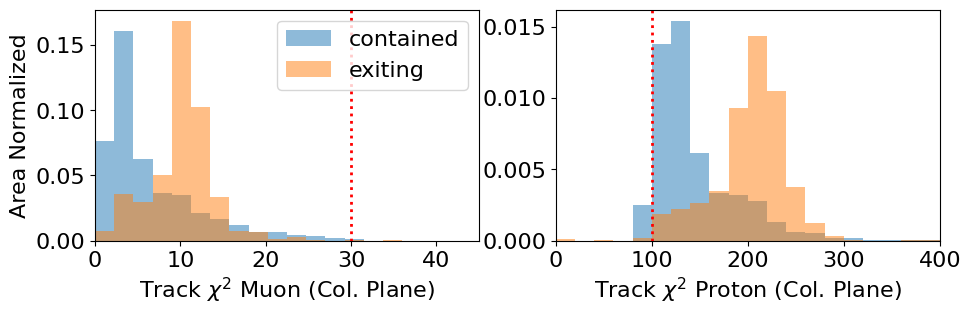

In [12]:
# Jamie 11.20.23: Put them side by side.

plt.figure(figsize=(10.9,3))
mybins = 20
myDensity = True

# Muon x2

plt.subplot(1,2,1)
myrange = (0,45)
print(np.max(evtdf.trunk.trk.chi2pid.I2.chi2_muon))
plt.hist(np.concatenate((evtdf[when_branch_con].branch.trk.chi2pid.I2.chi2_muon,
                        evtdf[when_trunk_con].trunk.trk.chi2pid.I2.chi2_muon)), 
         label='contained', bins=mybins, range=myrange, linewidth=2, density=myDensity, alpha=0.5)
plt.hist(np.concatenate((evtdf[when_trunk_unc].trunk.trk.chi2pid.I2.chi2_muon, 
                         evtdf[when_branch_unc].branch.trk.chi2pid.I2.chi2_muon)), 
         label='exiting', bins=mybins, range=myrange, linewidth=2, density=myDensity, alpha=0.5)
plt.axvline([30], linestyle=":", color="red", linewidth=2)
plt.xlim(myrange)
plt.legend(loc='upper right')
plt.xlabel("Track $\\chi^2$ Muon (Col. Plane)")
if myDensity == True:
    plt.ylabel("Area Normalized")

# Proton x2

plt.subplot(1,2,2)
myrange = (0,400)
print(np.max(evtdf.trunk.trk.chi2pid.I2.chi2_proton))
plt.hist(np.concatenate((evtdf[when_branch_con].branch.trk.chi2pid.I2.chi2_proton,
                        evtdf[when_trunk_con].trunk.trk.chi2pid.I2.chi2_proton)), label='contained',
         bins=mybins, range=myrange, linewidth=2, density=myDensity, alpha=0.5)
plt.hist(np.concatenate((evtdf[when_trunk_unc].trunk.trk.chi2pid.I2.chi2_proton, 
                         evtdf[when_branch_unc].branch.trk.chi2pid.I2.chi2_proton)), label='exiting',
         bins=mybins, range=myrange, linewidth=2, density=myDensity, alpha=0.5)
plt.axvline([100], linestyle=":", color="red", linewidth=2)
plt.xlim(myrange)
#plt.legend()
plt.xlabel("Track $\\chi^2$ Proton (Col. Plane)")
#if myDensity == True:
#    plt.ylabel("Area Normalized")

###    

plt.show()


In [13]:
print(evtdf.shape)

a = np.concatenate((evtdf[when_branch_con].branch.trk.chi2pid.I2.chi2_muon,
                    evtdf[when_trunk_con].trunk.trk.chi2pid.I2.chi2_muon))
print(a.shape)

b = np.concatenate((evtdf[when_trunk_unc].trunk.trk.chi2pid.I2.chi2_proton, 
                    evtdf[when_branch_unc].branch.trk.chi2pid.I2.chi2_proton))
print(b.shape)

(2481, 186)
(3667,)
(1295,)


In [18]:
evtdf[when_trunk_con].trunk.trk.chi2pid.I2.chi2_muon

__ntuple  entry  rec.slc..index
1         0      0                  5.320666
          3      0                 12.777699
          8      0                  3.728868
          17     12                 8.133431
          20     19                29.760399
                                     ...    
403       2      25                 6.754510
          8      0                 16.493389
          15     1                  2.054991
          20     13                 5.992342
          22     0                  5.165821
Name: chi2_muon, Length: 2337, dtype: float32

In [19]:
evtdf

slc                          \
                              is_clear_cosmic      vertex               
                                                        x           y   
                                                                        
                                                                        
                                                                        
__ntuple entry rec.slc..index                                           
1        0     0                            0 -296.280212   98.545502   
         3     0                            0 -220.342621   84.423111   
         8     0                            0 -168.458466 -120.352470   
         15    20                           0  161.984924    3.730591   
         17    12                           0  178.943176  118.468117   
..                                        ...         ...         ...   
403      8     0                            0 -253.997742   86.235718   
         12    41                           0  101.329391  -67.208435   
         15    1                            0 -290.240723   82.419495   
         20    13                           0  261.973877   47.367706   
         22    0                            0 -256.650330   39.035065   

                                                                         \
                                          self    tmatch                  
                                        z            eff       pur  idx   
                                                                          
                                                                          
                                                                          
__ntuple entry rec.slc..index                                             
1        0     0              -617.396545  177  0.817304  0.987288    0   
         3     0              -295.191986  220  0.852543  0.990502    0   
         8     0               -43.930634  227  0.899656  0.990000    0   
         15    20              602.601685  286       NaN       NaN -999   
         17    12               32.523952  257  0.728989  0.989488    0   
..                                    ...  ...       ...       ...  ...   
403      8     0               291.277191  158       NaN       NaN -999   
         12    41              174.627686  319       NaN       NaN -999   
         15    1              -806.306213   93  0.862291  0.982926    0   
         20    13             -597.972046  263  0.921968  0.928038    0   
         22    0               536.903870  124  0.874962  0.953915    0   

                                                      ...  \
                              producer          nuid  ...   
                                       crlongtrkdiry  ...   
                                                      ...   
                                                      ...   
                                                      ...   
__ntuple entry rec.slc..index                         ...   
1        0     0                     0     -0.309843  ...   
         3     0                     0      0.081971  ...   
         8     0                     0      0.632349  ...   
         15    20                    1     -0.939281  ...   
         17    12                    1     -0.071571  ...   
..                                 ...           ...  ...   
403      8     0                     0     -0.307782  ...   
         12    41                    1     -0.978130  ...   
         15    1                     0     -0.126278  ...   
         20    13                    1     -0.189728  ...   
         22    0                     0     -0.377362  ...   

                              third_trk_chi2_proton third_trk_chi2_muon  \
                                                                          
                                                                          
                                                    

My interpretation of above plots:
    
It looks like the xi2 thresholds used for the contained tracks will also work for the uncontained tracks (at least looking at these signal-only distributions).

# Check the Tracks' Length

### Note: Upstream, when the dataframes for the samples were made, a ( track length >= 100 cm ) requirement was imposed for uncontained tracks.

How long of a length do you need to require to get down to zero background?

784.78534


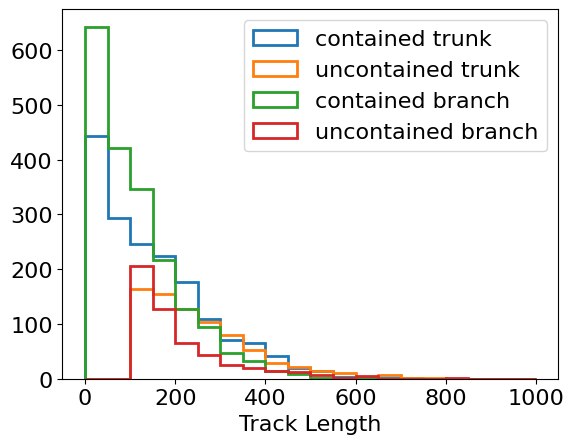

In [13]:
mybins = 20
myrange = (0,1000)
myDensity = False
print(np.max(evtdf.trunk.trk.len)) 
plt.hist(evtdf[when_trunk_con].trunk.trk.len, histtype = 'step', 
         label='contained trunk', bins=mybins, range=myrange, linewidth=2, density=myDensity)
plt.hist(evtdf[when_trunk_unc].trunk.trk.len, histtype = 'step', 
         label='uncontained trunk', bins=mybins, range=myrange, linewidth=2, density=myDensity)
plt.hist(evtdf[when_branch_con].branch.trk.len, histtype = 'step', 
         label='contained branch', bins=mybins, range=myrange, linewidth=2, density=myDensity)
plt.hist(evtdf[when_branch_unc].branch.trk.len, histtype = 'step', 
         label='uncontained branch', bins=mybins, range=myrange, linewidth=2, density=myDensity)
plt.legend()
plt.xlabel("Track Length")
if myDensity == True:
    plt.ylabel("Area Normalized")
plt.show()

# Compare True and Reconstructed Scalar Angle wrt NuMI For Different Methods of Obtaining the Uncontained Tracks' Momenta (i.e. direction):

In [35]:
for c in unc_h_evtdf.trunk.trk.columns:
    print(c)

('producer', '', '', '')
('start', 'x', '', '')
('start', 'y', '', '')
('start', 'z', '', '')
('end', 'x', '', '')
('end', 'y', '', '')
('end', 'z', '', '')
('dir', 'x', '', '')
('dir', 'y', '', '')
('dir', 'z', '', '')
('len', '', '', '')
('rangeP', 'p_muon', '', '')
('mcsP', 'fwdP_muon', '', '')
('rangeP', 'p_pion', '', '')
('mcsP', 'fwdP_pion', '', '')
('bestplane', '', '', '')
('crthit', 'distance', '', '')
('crthit', 'hit', 'time', '')
('crthit', 'hit', 'pe', '')
('chi2pid', 'I2', 'pid_ndof', '')
('chi2pid', 'I2', 'chi2_muon', '')
('chi2pid', 'I2', 'chi2_proton', '')
('chi2pid', 'I2', 'pida', '')
('truth', 'p', 'start_process', '')
('truth', 'p', 'end_process', '')
('truth', 'p', 'pdg', '')
('truth', 'p', 'startE', '')
('truth', 'p', 'start', 'x')
('truth', 'p', 'start', 'y')
('truth', 'p', 'start', 'z')
('truth', 'p', 'end', 'x')
('truth', 'p', 'end', 'y')
('truth', 'p', 'end', 'z')
('truth', 'p', 'genp', 'x')
('truth', 'p', 'genp', 'y')
('truth', 'p', 'genp', 'z')
('truth', 'p',

In [14]:
print_stuff = True
if print_stuff:
    print(Sbeamangle(unc_evtdf.trunk.trk, unc_evtdf.branch.trk, BEAMDIR, 'track_truth')[0])
    print(Sbeamangle(unc_evtdf.trunk.trk, unc_evtdf.branch.trk, BEAMDIR, 'range')[0])
    print(Sbeamangle(unc_evtdf.trunk.trk, unc_evtdf.branch.trk, BEAMDIR, 'mcs')[0])
    print(Sbeamangle(unc_evtdf.trunk.trk, unc_evtdf.branch.trk, BEAMDIR, 'weight_by_len')[0])
    print(Sbeamangle(unc_evtdf.trunk.trk, unc_evtdf.branch.trk, BEAMDIR, 'dir_only')[0])

entry  rec.slc..index
13     1                 0.071692
6      15                0.036688
dtype: float32
entry  rec.slc..index
13     1                 0.067211
6      15                0.047852
dtype: float32
entry  rec.slc..index
13     1                 0.061240
6      15                0.046696
dtype: float32
entry  rec.slc..index
13     1                 0.077348
6      15                0.055090
dtype: float32
entry  rec.slc..index
13     1                 0.036009
6      15                0.023766
dtype: float32


2.8890264


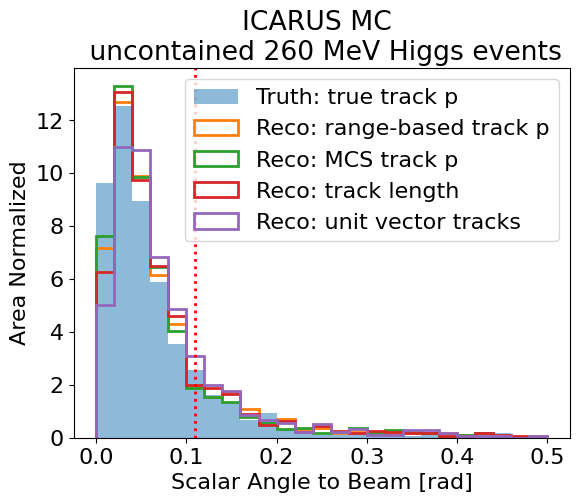

2.8890264


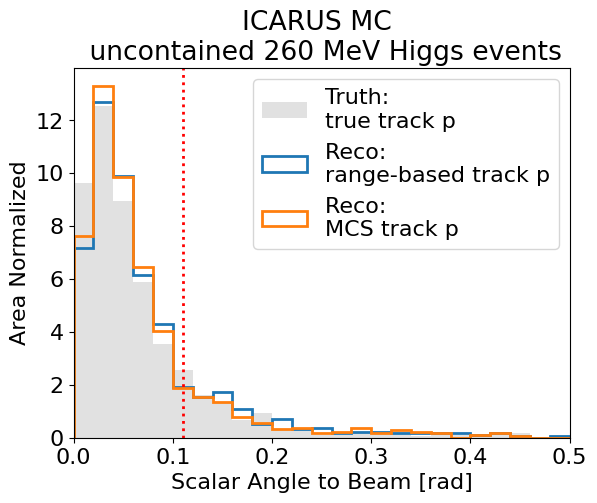

In [15]:

mybins = 25
myrange = (0,0.5) #np.pi)
myDensity = True
print(np.max(Sbeamangle(unc_evtdf.trunk.trk, unc_evtdf.branch.trk, BEAMDIR, 'track_truth'))) 
plt.hist(Sbeamangle(unc_evtdf.trunk.trk, unc_evtdf.branch.trk, BEAMDIR, 'track_truth'), 
         alpha=0.5, bins=mybins, range=myrange, linewidth=2, density=myDensity, 
         label='Truth: true track p')
plt.hist(Sbeamangle(unc_evtdf.trunk.trk, unc_evtdf.branch.trk, BEAMDIR, 'range'), 
         histtype = 'step', bins=mybins, range=myrange, linewidth=2, density=myDensity, 
         label='Reco: range-based track p')
plt.hist(Sbeamangle(unc_evtdf.trunk.trk, unc_evtdf.branch.trk, BEAMDIR, 'mcs'), 
         histtype = 'step', bins=mybins, range=myrange, linewidth=2, density=myDensity, 
         label='Reco: MCS track p')
plt.hist(Sbeamangle(unc_evtdf.trunk.trk, unc_evtdf.branch.trk, BEAMDIR, 'weight_by_len'), 
         histtype = 'step', bins=mybins, range=myrange, linewidth=2, density=myDensity, 
         label='Reco: track length')
plt.hist(Sbeamangle(unc_evtdf.trunk.trk, unc_evtdf.branch.trk, BEAMDIR, 'dir_only'), 
         histtype = 'step', bins=mybins, range=myrange, linewidth=2, density=myDensity, 
         label='Reco: unit vector tracks')
plt.axvline([0.11], linestyle=":", color="red", linewidth=2)
plt.title('ICARUS MC \n uncontained 260 MeV Higgs events')
plt.legend()
plt.xlabel("Scalar Angle to Beam [rad]")
if myDensity == True:
    plt.ylabel("Area Normalized")
plt.show()

# Use for prelim:

mybins = 25
myrange = (0,0.5) #np.pi)
myDensity = True
print(np.max(Sbeamangle(unc_evtdf.trunk.trk, unc_evtdf.branch.trk, BEAMDIR, 'track_truth'))) 
plt.hist(Sbeamangle(unc_evtdf.trunk.trk, unc_evtdf.branch.trk, BEAMDIR, 'track_truth'), 
         alpha=0.5, bins=mybins, range=myrange, linewidth=2, density=myDensity, 
         label='Truth: \ntrue track p', color='#C4C4C5')
plt.hist(Sbeamangle(unc_evtdf.trunk.trk, unc_evtdf.branch.trk, BEAMDIR, 'range'), 
         histtype = 'step', bins=mybins, range=myrange, linewidth=2, density=myDensity, 
         label='Reco: \nrange-based track p')
plt.hist(Sbeamangle(unc_evtdf.trunk.trk, unc_evtdf.branch.trk, BEAMDIR, 'mcs'), 
         histtype = 'step', bins=mybins, range=myrange, linewidth=2, density=myDensity, 
         label='Reco: \nMCS track p')
plt.axvline([0.11], linestyle=":", color="red", linewidth=2)
plt.title('ICARUS MC \n uncontained 260 MeV Higgs events')
plt.legend()
plt.xlim(myrange)
plt.xlabel("Scalar Angle to Beam [rad]")
if myDensity == True:
    plt.ylabel("Area Normalized")
plt.show()

# Compare true and reco momenta

In [16]:
when_trunk_con = SlcInFV(evtdf.slc.vertex) & TrkInFV(evtdf.trunk.trk.end) 
when_trunk_unc = SlcInFV(evtdf.slc.vertex) & ~TrkInFV(evtdf.trunk.trk.end)
when_branch_con = SlcInFV(evtdf.slc.vertex) & TrkInFV(evtdf.branch.trk.end)
when_branch_unc = SlcInFV(evtdf.slc.vertex) & ~TrkInFV(evtdf.branch.trk.end)

In [17]:
print(when_trunk_con.shape)
print(getp(evtdf[when_trunk_con].trunk.trk, 'track_truth').shape)
print(getp(evtdf[when_trunk_con].branch.trk, 'track_truth').shape)
print(type(getp(evtdf[when_trunk_con].trunk.trk, 'track_truth')))

print(np.concatenate(( 
    np.array(getp(evtdf[when_trunk_con].branch.trk, 'track_truth')), 
    np.array(getp(evtdf[when_trunk_con].trunk.trk, 'track_truth'))
)).shape)

(2481,)
(1714,)
(1714,)
<class 'pandas.core.series.Series'>
(3428,)


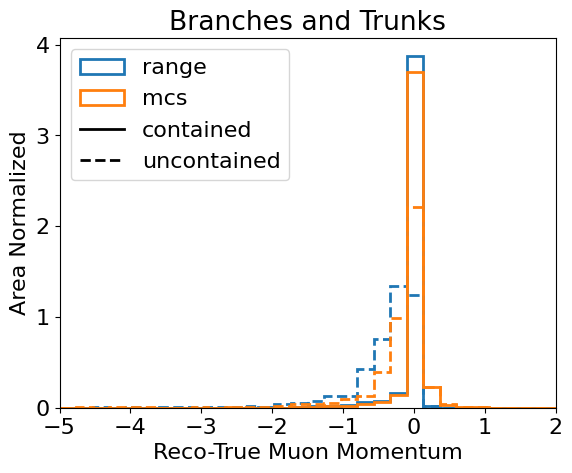

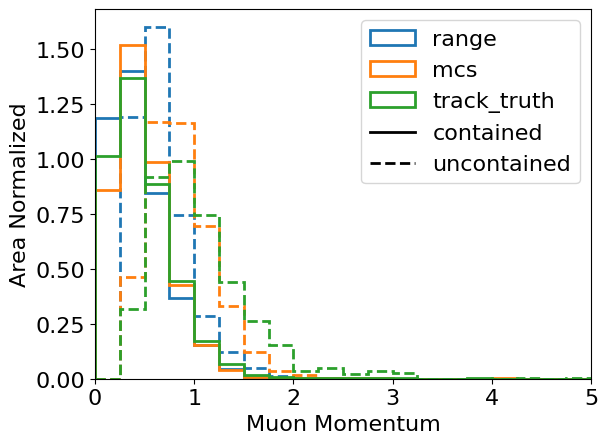

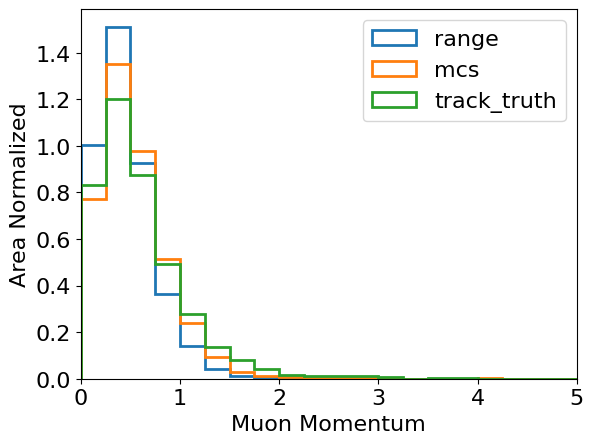

In [18]:
# PLOT RECO - TRUE FOR RANGE-BASED AND MCS

mybins = 30
myrange = (-5,2)
myDensity = True
#print(np.max(h_evtdf.trunk.trk.chi2pid.I2.chi2_muon))
methods = ['range', 'mcs']
colors = ['C0', 'C1']
for i in range(len(methods)):
    plt.hist(np.concatenate((
        (getp(evtdf[when_trunk_con].trunk.trk, methods[i]) - 
         getp(evtdf[when_trunk_con].trunk.trk, 'track_truth')), 
        (getp(evtdf[when_branch_con].branch.trk, methods[i]) - 
         getp(evtdf[when_branch_con].branch.trk, 'track_truth')) 
    )),
             histtype = 'step', linestyle='-', color=colors[i],
             label=methods[i], bins=mybins, range=myrange, linewidth=2, density=myDensity
            )
    plt.hist(np.concatenate((
        (getp(evtdf[when_trunk_unc].trunk.trk, methods[i]) - 
         getp(evtdf[when_trunk_unc].trunk.trk, 'track_truth')), 
        (getp(evtdf[when_branch_unc].branch.trk, methods[i]) - 
         getp(evtdf[when_branch_unc].branch.trk, 'track_truth')) 
    )),
             histtype = 'step', linestyle='--', color=colors[i],
             bins=mybins, range=myrange, linewidth=2, density=myDensity
            )
#    plt.hist(getp(h_evtdf[when_trunk_unc].trunk.trk, methods[i]), 
#             histtype = 'step', linestyle='--', color=colors[i], 
#             bins=mybins, range=myrange, linewidth=2, density=myDensity)
plt.axvline([20], linestyle="-", color="black", linewidth=2, label='contained')
plt.axvline([20], linestyle="--", color="black", linewidth=2, label='uncontained')
plt.legend(ncol=1, loc='upper left')
plt.xlabel("Reco-True Muon Momentum")
plt.xlim(myrange)
plt.title('Branches and Trunks')
if myDensity == True:
    plt.ylabel("Area Normalized")
plt.show()

# PLOT DISTRIBUTIONS AT FACE VALUE: trunks only

mybins = 20
myrange = (0,5)
myDensity = True
#print(np.max(h_evtdf.trunk.trk.chi2pid.I2.chi2_muon))
methods = ['range', 'mcs', 'track_truth']
colors = ['C0', 'C1', 'C2']
for i in range(len(methods)):
    plt.hist(getp(evtdf[when_trunk_con].trunk.trk, methods[i]), 
             histtype = 'step', linestyle='-', color=colors[i],
             label=methods[i], bins=mybins, range=myrange, linewidth=2, density=myDensity)
    plt.hist(getp(evtdf[when_trunk_unc].trunk.trk, methods[i]), 
             histtype = 'step', linestyle='--', color=colors[i], 
             bins=mybins, range=myrange, linewidth=2, density=myDensity)
plt.axvline([20], linestyle="-", color="black", linewidth=2, label='contained')
plt.axvline([20], linestyle="--", color="black", linewidth=2, label='uncontained')
plt.legend(ncol=1, loc='upper right')
plt.xlabel("Muon Momentum")
plt.xlim(myrange)
if myDensity == True:
    plt.ylabel("Area Normalized")
plt.show()

# don't separated based on containment

mybins = 20
myrange = (0,5)
myDensity = True
methods = ['range', 'mcs', 'track_truth']
colors = ['C0', 'C1', 'C2']
for i in range(len(methods)):
    plt.hist(np.concatenate((getp(evtdf.trunk.trk, methods[i]), getp(evtdf.branch.trk, methods[i]) )),
             histtype = 'step', linestyle='-', color=colors[i],
             label=methods[i], bins=mybins, range=myrange, linewidth=2, density=myDensity)
plt.legend(ncol=1, loc='upper right')
plt.xlabel("Muon Momentum")
plt.xlim(myrange)
if myDensity == True:
    plt.ylabel("Area Normalized")
plt.show()



In [19]:
con_range = np.concatenate((
    (getp(evtdf[when_trunk_con].trunk.trk, 'range') - 
     getp(evtdf[when_trunk_con].trunk.trk, 'track_truth')), 
    (getp(evtdf[when_branch_con].branch.trk, 'range') - 
     getp(evtdf[when_branch_con].branch.trk, 'track_truth'))
))
print(np.max(np.abs(con_range)))

con_mcs = np.concatenate((
    (getp(evtdf[when_trunk_con].trunk.trk, 'mcs') - 
     getp(evtdf[when_trunk_con].trunk.trk, 'track_truth')), 
    (getp(evtdf[when_branch_con].branch.trk, 'mcs') - 
     getp(evtdf[when_branch_con].branch.trk, 'track_truth'))
))   
print(np.max(np.abs(con_mcs)))

unc_range = np.concatenate((
    (getp(evtdf[when_trunk_unc].trunk.trk, 'range') - 
     getp(evtdf[when_trunk_unc].trunk.trk, 'track_truth')), 
    (getp(evtdf[when_branch_unc].branch.trk, 'range') - 
     getp(evtdf[when_branch_unc].branch.trk, 'track_truth')) 
))
print(np.max(np.abs(unc_range)))

unc_mcs = np.concatenate((
    (getp(evtdf[when_trunk_unc].trunk.trk, 'mcs') - 
     getp(evtdf[when_trunk_unc].trunk.trk, 'track_truth')), 
    (getp(evtdf[when_branch_unc].branch.trk, 'mcs') - 
     getp(evtdf[when_branch_unc].branch.trk, 'track_truth')) 
))
print(np.max(np.abs(unc_mcs)))
print('')

var = unc_mcs
myrange=(-2,1)
print(type(myrange))
out_of_range = [( (el < myrange[0]) | (el > myrange[1]) ) for el in var]
print(var.shape)
print(var[out_of_range].shape)


#test = np.array([1,2,3,4,5,6])
#mask = [el not in range(3,5) for el in test]
#mask
#test[mask]

10.066035
9.283026
38.36688
38.419685

<class 'tuple'>
(1295,)
(14,)


8.081458
Out of range values: 198 / 3667 (=5.399509135533133 %)
62.69435
Out of range values: 293 / 3667 (=7.990182710662667 %)
1.1448404
Out of range values: 1 / 1295 (=0.07722007722007722 %)
1.0019774
Out of range values: 1 / 1295 (=0.07722007722007722 %)


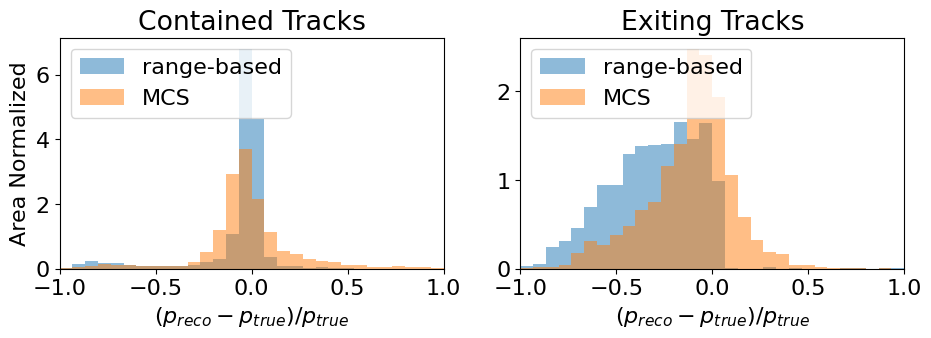

In [20]:
# Redo for Prelim: Side by side plots for contained and Exiting.

# PLOT RECO - TRUE FOR RANGE-BASED AND MCS

plt.figure(figsize=(10.9,3))
mybins = 30
myDensity = True
methods = ['range', 'mcs']
labels = ['range-based', 'MCS']
colors = ['C0', 'C1']


# Contained  

myrange=(-1,1)
plt.subplot(1,2,1)
for i in range(len(methods)):
    var = np.concatenate((
        (getp(evtdf[when_trunk_con].trunk.trk, methods[i]) - 
         getp(evtdf[when_trunk_con].trunk.trk, 'track_truth'))/getp(evtdf[when_trunk_con].trunk.trk, 'track_truth'), 
        (getp(evtdf[when_branch_con].branch.trk, methods[i]) - 
         getp(evtdf[when_branch_con].branch.trk, 'track_truth'))/getp(evtdf[when_branch_con].branch.trk, 'track_truth') 
    ))
    print(np.max(np.abs(var)))
    out_of_range = [( (el < myrange[0]) | (el > myrange[1]) ) for el in var]
    print('Out of range values: %a / %a (=%a %%)' % 
          (var[out_of_range].shape[0], var.shape[0], 100.*var[out_of_range].shape[0]/var.shape[0]) )
    plt.hist(var, alpha=0.5, color=colors[i], label=labels[i], 
             bins=mybins, range=myrange, linewidth=2, density=myDensity
            )
#plt.yscale('log')
plt.legend(ncol=1, loc='upper left')
plt.xlabel("$(p_{reco} - p_{true})/p_{true}$")
plt.xlim(myrange)
plt.title('Contained Tracks')
if myDensity == True:
    plt.ylabel("Area Normalized")

# Exiting

#myrange=(-1,2)
plt.subplot(1,2,2)
for i in range(len(methods)):
    var = np.concatenate((
        (getp(evtdf[when_trunk_unc].trunk.trk, methods[i]) - 
         getp(evtdf[when_trunk_unc].trunk.trk, 'track_truth'))/getp(evtdf[when_trunk_unc].trunk.trk, 'track_truth'), 
        (getp(evtdf[when_branch_unc].branch.trk, methods[i]) - 
         getp(evtdf[when_branch_unc].branch.trk, 'track_truth'))/getp(evtdf[when_branch_unc].branch.trk, 'track_truth')
    ))
    print(np.max(np.abs(var)))
    out_of_range = [( (el < myrange[0]) | (el > myrange[1]) ) for el in var]
    print('Out of range values: %a / %a (=%a %%)' % 
          (var[out_of_range].shape[0], var.shape[0], 100.*var[out_of_range].shape[0]/var.shape[0]) )
    plt.hist(var, alpha=0.5, color=colors[i], label=labels[i],
             bins=mybins, range=myrange, linewidth=2, density=myDensity
            )
#plt.yscale('log')
plt.legend(ncol=1, loc='upper left')
plt.xlabel("$(p_{reco} - p_{true})/p_{true}$")
plt.xlim(myrange)
plt.title('Exiting Tracks')
#if myDensity == True:
#    plt.ylabel("Area Normalized")

plt.show()
###



In [51]:
out_of_range
if range(myrange[0], myrange[1]) == range(-2, 1): print('yes')

yes


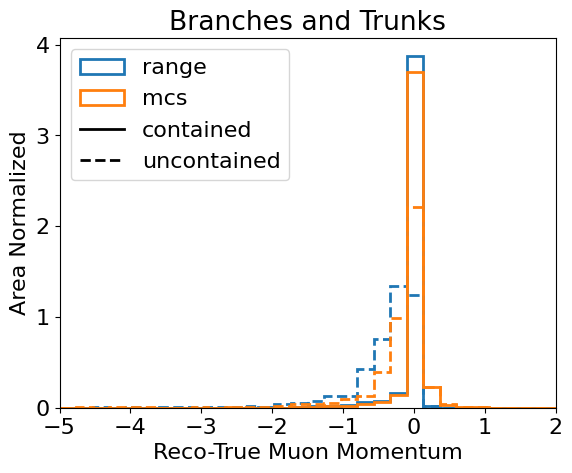

In [21]:
# PLOT RECO - TRUE FOR RANGE-BASED AND MCS

mybins = 30
myrange = (-5,2)
myDensity = True
#print(np.max(h_evtdf.trunk.trk.chi2pid.I2.chi2_muon))
methods = ['range', 'mcs']
colors = ['C0', 'C1']
for i in range(len(methods)):
    plt.hist(np.concatenate((
        (getp(evtdf[when_trunk_con].trunk.trk, methods[i]) - 
         getp(evtdf[when_trunk_con].trunk.trk, 'track_truth')), 
        (getp(evtdf[when_branch_con].branch.trk, methods[i]) - 
         getp(evtdf[when_branch_con].branch.trk, 'track_truth')) 
    )),
             histtype = 'step', linestyle='-', color=colors[i],
             label=methods[i], bins=mybins, range=myrange, linewidth=2, density=myDensity
            )
    plt.hist(np.concatenate((
        (getp(evtdf[when_trunk_unc].trunk.trk, methods[i]) - 
         getp(evtdf[when_trunk_unc].trunk.trk, 'track_truth')), 
        (getp(evtdf[when_branch_unc].branch.trk, methods[i]) - 
         getp(evtdf[when_branch_unc].branch.trk, 'track_truth')) 
    )),
             histtype = 'step', linestyle='--', color=colors[i],
             bins=mybins, range=myrange, linewidth=2, density=myDensity
            )
#    plt.hist(getp(h_evtdf[when_trunk_unc].trunk.trk, methods[i]), 
#             histtype = 'step', linestyle='--', color=colors[i], 
#             bins=mybins, range=myrange, linewidth=2, density=myDensity)
plt.axvline([20], linestyle="-", color="black", linewidth=2, label='contained')
plt.axvline([20], linestyle="--", color="black", linewidth=2, label='uncontained')
plt.legend(ncol=1, loc='upper left')
plt.xlabel("Reco-True Muon Momentum")
plt.xlim(myrange)
plt.title('Branches and Trunks')
if myDensity == True:
    plt.ylabel("Area Normalized")
plt.show()